# CAP 394 - Brazilian Savannas Vegetation Areas Identification Using MODIS MOD13Q1 Data

## 1. Introduction

In this work, the aim is to use MODIS MOD13Q1 data to identify remaining areas of brazilian savannas. The data are available through an INPE server, accessed with the _wtss_ python package. 6 data types will be used:

+ Digital Number:
    + Blue
    + Red
    + NIR
    + MIR
+ Vegetation Indexes:
    + NDVI
    + EVI
    
The identification of the brazilian savannas remaining areas is going to be done using machine learning algorithms, more specifically, a DTW ( _Dynamic Time Warping_ ). To use such type of algorithms, a training set have to be used, in this case, a set of training data was acquired by the analyst by visual interpretation.

<img src="./Images/graph.png" width="700">

Below can be found the packages needed in the project.

In [1]:
from IPython.display import HTML
from fastdtw import fastdtw
from functools import partial
from joblib import Parallel, delayed
from scipy.spatial.distance import euclidean
from shapely.geometry import shape, Point
from shapely.geometry.polygon import Polygon
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import cohen_kappa_score as kappa
from time import time
from tqdm import tqdm_notebook as tqdm
from wtss import wtss
import gdal
import geopandas as gp
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import os
import shapefile as shp
import subprocess

## 2. Study Area

The area chosen for the classification is the municipality of São Desidério, located at the west region of the Bahia state. The region is characterized by large areas of agriculture, being the grains production the main activity. The municipality is entirely inside the Cerrado biome, and more information about it can be found in [here (portuguese)](https://pt.wikipedia.org/wiki/S%C3%A3o_Desid%C3%A9rio).

To obtain the boundaries of the study area, a shapefile was downloaded from Instituto Basileiro de Geografia e Estatística (IBGE) from this [link](ftp://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2015/Brasil/BR/br_municipios.zip) and saved to the computer.

The following code is used to load the shapefile as a dataset in geopandas, and the data associated to the geometries can be seen.

NM_MUNICIP CD_GEOCMU  \
0                       CAIUÁ   3509106   
1                    CASTILHO   3511003   
2                     DRACENA   3514403   
3            ESTRELA DO NORTE   3515301   
4  EUCLIDES DA CUNHA PAULISTA   3515350   

                                            geometry  
0  POLYGON ((-51.86001052999998 -21.5807199056459...  
1  POLYGON ((-51.41936432700003 -20.6810765586240...  
2  POLYGON ((-51.48515406800003 -21.4276462056422...  
3  POLYGON ((-51.57097467399996 -22.3988718766653...  
4  POLYGON ((-52.44569233499996 -22.6082794076701...

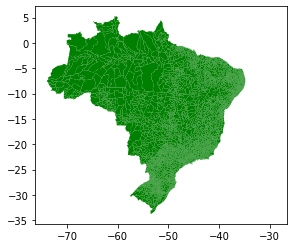

In [2]:
path = "/home/bruno/Documents/BR/BRMUE250GC_SIR.shp"

brasil = gp.read_file(path, encoding="utf-8")

brasil.plot(color='green')
brasil.head()

As we can see, there is an attribute called "NM_MUNICIP", which contains the name of each brazilian municipality, so, the São Desidério munipality and its Coordenate Reference System (CRS) can be extracted with the following code.

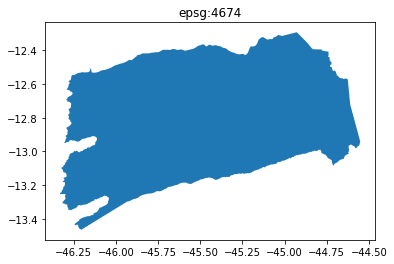

In [3]:
sao_desiderio = brasil[brasil["NM_MUNICIP"]=="SÃO DESIDÉRIO"]

sao_desiderio.plot()
plt.title(str(sao_desiderio.crs['init']))

brasil = None

It can be noticed that the municipality's CRS is "epsg: 4674". The MODIS data used in this project can be projected in a different CRS, so it should be checked, in case a projection for the municipality is needed. The following code show what is the MODIS data CRS.

In [4]:
w = wtss("http://www.esensing.dpi.inpe.br")

cv_scheme = w.describe_coverage("MOD13Q1")
ts = w.time_series("MOD13Q1", "ndvi", -12.532790, -45.199361, 
                   start_date="2017-01-01", end_date="2018-01-01").timeline

print(cv_scheme['crs']['wkt'])

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]


In the end if the output, it can be seen that the MODIS data provided is in the "EPSG: 4326" CRS, so, a transformation is needed in order to make the data compatible.

The projected boundaries are then stored into a shapefile, to be used later.

Text(0.5, 1, 'epsg:4326')

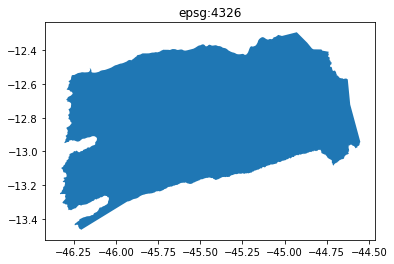

In [5]:
sao_desiderio = sao_desiderio.to_crs({'init': 'epsg:4326'})

sao_desiderio.to_file("./Data/Shape/sao_desiderio_epsg4326.shp",  encoding="utf-8")

sao_desiderio.plot()
plt.title(str(sao_desiderio.crs['init']))

##  3. Data acquisition

Time series data will be used, so, somehow they have to be retrieved. In this project, this date will be acquired using a python package called **wtss**. This package can be used to access data cubes and its metadata. More information about the package can be found in [here](https://github.com/e-sensing/wtss.py). The package is used to access the data, but first the data must be made available by a provider, in this project, data provided by INPE is going to be used, from the product MOD13Q1 of the MODIS aquisition platform.

### 3.1 Time Series of a Point

The function below uses the latitude and longitude of a point to retrieve the corresponding time series. Other input parameters are the coverage wanted and the start and end dates of the series. The function also needs a polygon in the Shapely package format, so the function can check if the point is inside the polygon area, and avoid unnecessary time series retrieval.

The output is "None" if the point is not within the polygon, otherwise it will return an array with the time series values according to the coverage wanted.

In [6]:
# lat: float
# long: float
# series: string
# coverage: string
# date1: string like 2019-10-23
# date2: string like 2019-12-28
# poly: shapely polygon

def retrieveDataFromPoint(lat, long, series, coverage, date1, date2, poly):
    
    pt = Point(long, lat)
    
    if poly.contains(pt):
        result = None
        while result is None:
            try:
                w = wtss("http://www.esensing.dpi.inpe.br")
                ts = w.time_series(series, coverage, lat, long, start_date=date1, end_date=date2)
        
                return ts[coverage]
            except:
                pass
    else:
        return None

Below a line graph shows how a time series obtained with this function can be seen. In this case, an NDVI series for an area affected by the Fundão dam disaster.

/home/bruno/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


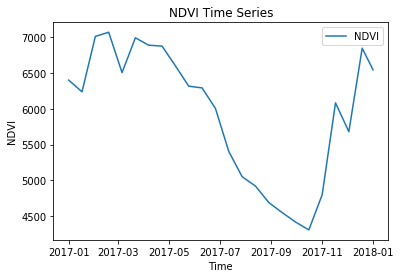

In [7]:
sf = shp.Reader("./Data/Shape/sao_desiderio_epsg4326.shp")
matplotDict = []

for shape in sf.shapeRecords(): # Iterate through shapes in shapefile
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    for i in x:
        matplotDict.append((x[x.index(i)], y[x.index(i)]))  # Convert coordinates to be read by Shapely pkg

    poly = Polygon(matplotDict)
    
cov = retrieveDataFromPoint(-12.532790, -45.199361, "MOD13Q1", "ndvi", 
                            "2017-01-01", "2018-01-01", poly)
plt.plot(ts, cov, label="NDVI")
plt.title("NDVI Time Series")
plt.xlabel("Time")
plt.ylabel("NDVI")
plt.legend()
plt.show()

### 3.2 Time Series in a Matrix

The function above _retrieveDataFromPoint( )_  gets the time series for a certain coordinate. This is useful to analyze the profile of a single point, but the aim is to find the areas, so it has to be spatialized. The function below gets one single time series in order to know the size of the array needed (lat, long and total number of dates). With the series dimensions, it creates a matrix to receive all the data retrieve within a polygon obtained via a shapefile saved to the computer.

A plot of the last frame of the time series is shwn, and then the 3 dimensional matrix for the the whole time series is stored into the computer.

The retrieval is made for a single data type at a time (blue, red, nir, mir, NDVI or EVI), using almost all cores of the computer processor. This data is used in the identification of the brazilian savannas areas.

In [8]:
def retrieveDataMatrix(lat1, lat2, long1, long2, t1, t2, series, coverage, poly):
    t = time()
    
    # Shows info
    print("------------------------- RETRIEVING "+coverage.upper()+" DATA --------------------------")

    print("Processing...")
    
    # server data
    w = wtss("http://www.esensing.dpi.inpe.br")

    # gets coverage info
    cv_scheme = w.describe_coverage(series)

    # range i (height) and j (width) based on the spatial resolution
    r_i = int((lat2-lat1)/cv_scheme["spatial_resolution"]["y"])+1
    r_j = int((long2-long1)/cv_scheme["spatial_resolution"]["x"])+1

    # print info about the n° of lines and columns
    y = (lat1+(lat2-lat1)/2)
    x = (long1+(long2-long1)/2)
    
    w = wtss("http://www.esensing.dpi.inpe.br")
    ts = w.time_series(series, coverage, lat1, long1, start_date=t1, end_date=t2)
    time_series =  ts.timeline
    data = ts[coverage]
    
    coord = []

    # loop that get all things done (get data of a point for a certain , retrieves mean value of data,
    for i in range(r_i):
        for j in range(r_j):
            y = lat1+i*cv_scheme["spatial_resolution"]["y"]
            x = long1+j*cv_scheme["spatial_resolution"]["x"]

            coord.append([y, x])
    
    with mp.Pool(processes=mp.cpu_count()) as pool:
        data = pool.starmap(partial(retrieveDataFromPoint), [(lat, long, series, coverage, t1, t2, poly) for (lat,long) in coord])
    
    # creates the variable to receive the data
    all_data = np.zeros((r_i, r_j, len(time_series)))
    
    for i in range(r_i):
        for j in range(r_j):
            if data[i*r_j+j]==None:
                all_data[i,j,:] = None
            else:
                for k in range(all_data.shape[2]):
                    all_data[i,j,k] = data[i*r_j+j][k]
    
    # saves the data
    np.save("./Data/Time_Series/dates.npy", time_series)
    np.save("./Data/Time_Series/"+coverage+".npy", all_data)
    
    print("Data shape:", all_data.shape)
    print("Data size: %.3f MB" % (os.path.getsize("./Data/Time_Series/"+coverage+".npy")*1e-6))
    
    print("Total time: %1e-6.3f minutes\n" % ((time()-t)/60))
    
    return all_data, r_i, r_j

As elucidated in the introduction, the bands used are blue, red, nir, mir and the vegetation indexes ndvi and evi. The following code handles the acquisition of the time series of the 6 datasets, and if the point term in the matrix does not lies within the polygon inserted, the series is filled with None values.

------------------------- RETRIEVING RED DATA --------------------------
Processing...
Data shape: (562, 854, 24)
Data size: 92.150 MB
Total time: 1.110952e+01-6.3f minutes
------------------------- RETRIEVING BLUE DATA --------------------------
Processing...
Data shape: (562, 854, 24)
Data size: 92.150 MB
Total time: 1.133773e+01-6.3f minutes
------------------------- RETRIEVING MIR DATA --------------------------
Processing...
Data shape: (562, 854, 24)
Data size: 92.150 MB
Total time: 1.089348e+01-6.3f minutes
------------------------- RETRIEVING NIR DATA --------------------------
Processing...
Data shape: (562, 854, 24)
Data size: 92.150 MB
Total time: 1.080037e+01-6.3f minutes
------------------------- RETRIEVING NDVI DATA --------------------------
Processing...
Data shape: (562, 854, 24)
Data size: 92.150 MB
Total time: 1.161114e+01-6.3f minutes
------------------------- RETRIEVING EVI DATA --------------------------
Processing...
Data shape: (562, 854, 24)
Data size: 92.150 M

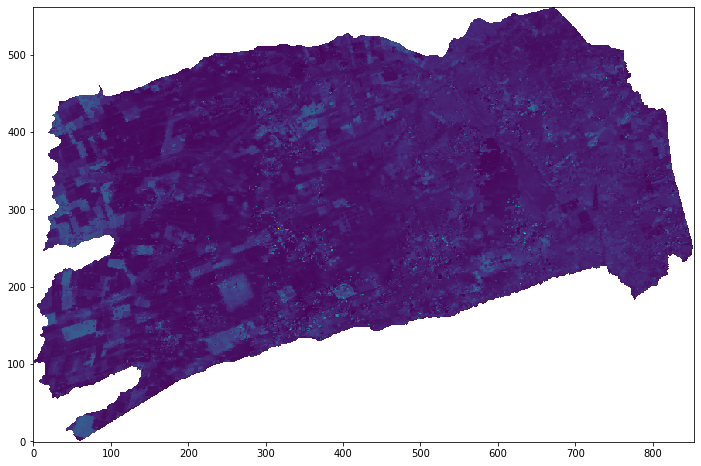

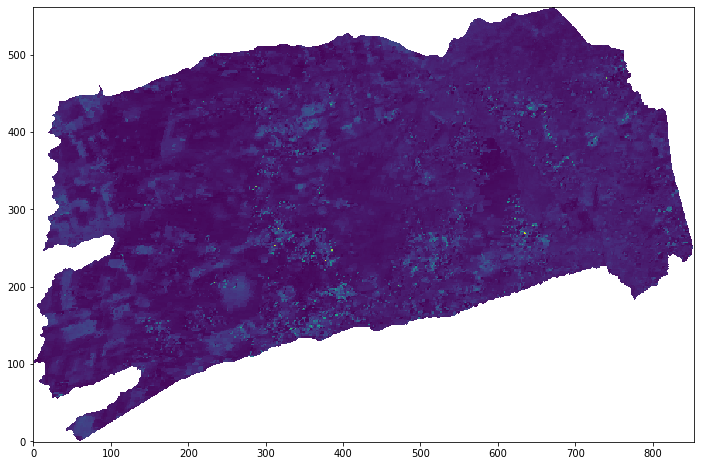

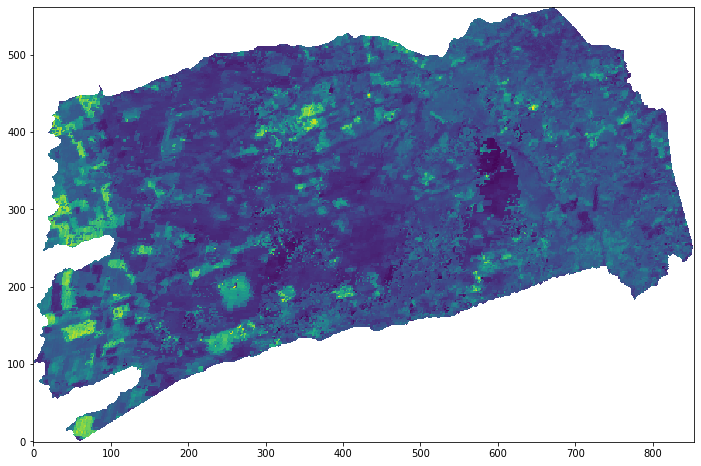

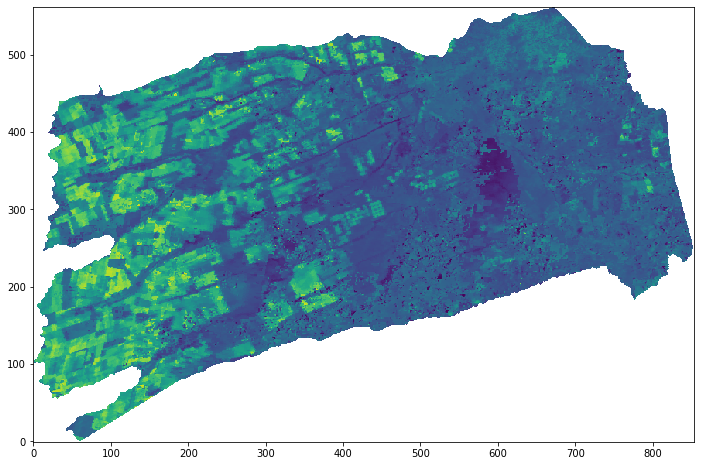

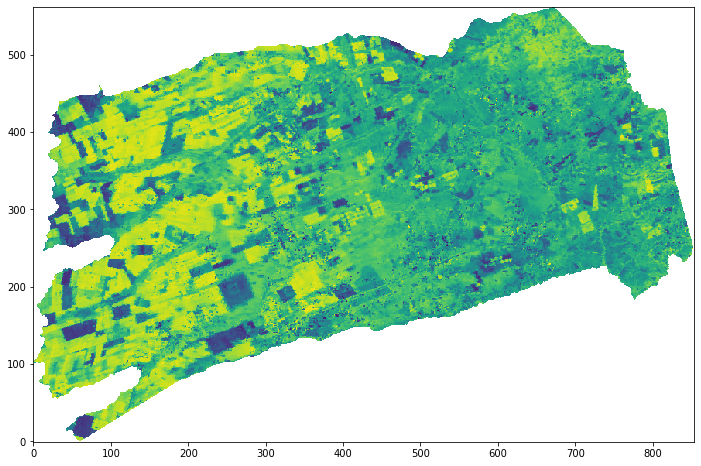

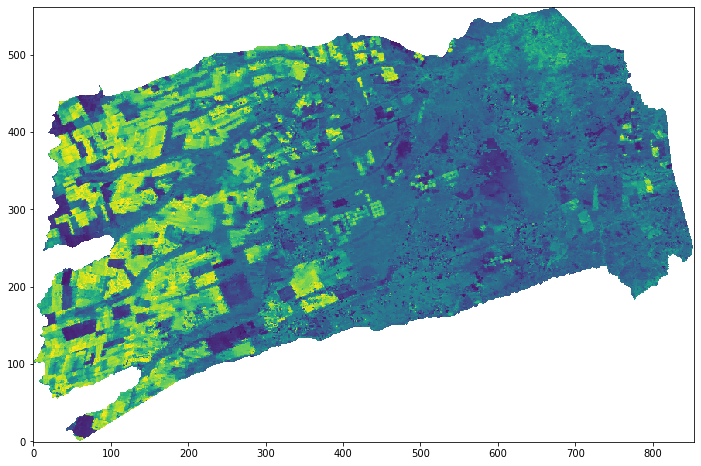

In [9]:
lat1 = float(sao_desiderio.bounds['miny'])
lat2 = float(sao_desiderio.bounds['maxy'])
long1 = float(sao_desiderio.bounds['minx'])
long2 = float(sao_desiderio.bounds['maxx'])

# abre o shapefile
sf = shp.Reader("./Data/Shape/sao_desiderio_epsg4326.shp")
matplotDict = []

for shape in sf.shapeRecords(): # Iterate through shapes in shapefile
    x = [i[0] for i in shape.shape.points[:]]  # Initially for use in matplotlib to check shapefile
    y = [i[1] for i in shape.shape.points[:]]  # Initially for use in matplotlib to check shapefile
    for i in x:
        matplotDict.append((x[x.index(i)], y[x.index(i)]))  # Convert coordinates to be read by Shapely pkg

    poly = Polygon(matplotDict)  # main

coverages = ["red", "blue", "mir", "nir", "ndvi", "evi"]

for cov in coverages:
    [all, r_i, r_j] = retrieveDataMatrix(lat1=lat1, lat2=lat2, 
                                     long1=long1, long2=long2, 
                                     t1="2017-01-01", t2="2018-01-01", 
                                     series="MOD13Q1", 
                                     coverage=cov, 
                                     poly=poly)

After the retrieval, the data was stored in the computer, and to access it, the following code is needed.

In [10]:
blue = np.load("./Data/Time_Series/blue.npy")
red = np.load("./Data/Time_Series/red.npy")
nir = np.load("./Data/Time_Series/nir.npy")
mir = np.load("./Data/Time_Series/mir.npy")
ndvi = np.load("./Data/Time_Series/ndvi.npy")
evi = np.load("./Data/Time_Series/evi.npy")
ts = np.load("./Data/Time_Series/dates.npy", allow_pickle=True)

print("Blue Shape:", blue.shape)
print("Red Shape:", red.shape)
print("Nir Shape:", nir.shape)
print("Mir Shape:", mir.shape)
print("NDVI Shape:", ndvi.shape)
print("EVI Shape:", evi.shape)
print("Time Series Shape:", ts.shape)

Blue Shape: (562, 854, 24)
Red Shape: (562, 854, 24)
Nir Shape: (562, 854, 24)
Mir Shape: (562, 854, 24)
NDVI Shape: (562, 854, 24)
EVI Shape: (562, 854, 24)
Time Series Shape: (24,)


### 3.3 Outliers & Filtering

The data used in the project is not any close of being perfectly clean. Many things can cause deviations on satellite data obtained with optical sensors, the biggest problem being the cloud and cloud shadows coverage in a scene. This two features have extreme different spectral behavior, the cloud being responsible for a saturation area in the picture, and the could shadow being responsible for a black area, with low signal. 

This type of coverage (clouds and clouds shadows) is not wanted in the project, due to the fact it hides the information of the ground reflectance under it. In this case, some algorithms can be used to minimize the effects of the cloud influence in the time series.

In the project, clouds and cloud's shadows are considered outliers, and therefore must be removed or diminished. The method chosen to do so is the algorithm described by Hamunyela _et al._ (2013), in this [paper](https://www.mdpi.com/2072-4292/5/12/6159). The function used to filter the outliers can be found below.

In [11]:
# ts: array of the time series values

def remove_outliers(ts):
    ts_corrected = ts.copy()
    per = 1/100

    for j in range(1, len(ts_corrected) - 1):
        if (ts[j]-ts[j-1]<-per*ts[j-1]) and (ts[j]-ts[j+1]<-per*ts[j+1]):
            ts_corrected[j] = (ts[j-1]+ts[j+1])/2

    return ts_corrected

An example of this algorithm's application can be seen below:

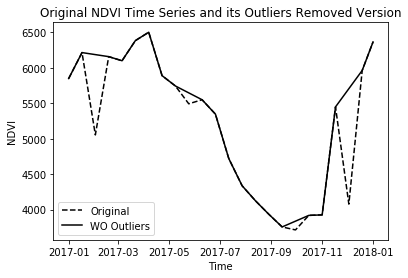

In [12]:
a = remove_outliers(ndvi[302,500,:])

plt.plot(ts,ndvi[302,500,:], "k--", label="Original")
plt.plot(ts,a, "k", label="WO Outliers")
plt.title("Original NDVI Time Series and its Outliers Removed Version")
plt.xlabel("Time")
plt.ylabel("NDVI")
plt.legend()
plt.show()

Removing the outliers is still not enough, the series need to be filtered in order to have a smother shape, what can improve the accuracy of the classification algorithms. The method chosen to filter the time series is the Savitzky-Golay filter, and was adapted from the implemetation found in [here (SciPy Cookbook)](https://scipy-cookbook.readthedocs.io/items/SavitzkyGolay.html).

In [13]:
# ts: array of the time series values

def filter_savitzky_golay(ts):
    from math import factorial
    window_size = 5
    order = 3
    deriv = 0
    rate = 1

    y = np.asarray(ts)

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        print("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order + 1)
    half_window = (window_size - 1) // 2
    # precompute coefficients
    b = np.mat([[k ** i for i in order_range] for k in range(-half_window, half_window + 1)])
    m = np.linalg.pinv(b).A[deriv] * rate ** deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs(y[1:half_window + 1][::-1] - y[0])
    lastvals = y[-1] + np.abs(y[-half_window - 1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve(m[::-1], y, mode='valid')

An example of this algorithm's application can be seen below:

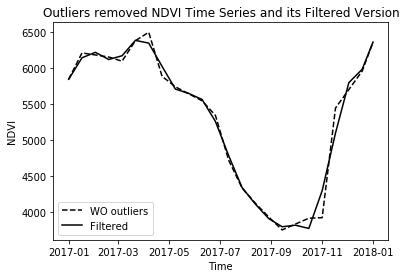

In [14]:
b = filter_savitzky_golay(a)

plt.plot(ts,a, "k--", label="WO outliers")
plt.plot(ts,b, "k", label="Filtered")
plt.title("Outliers removed NDVI Time Series and its Filtered Version")
plt.xlabel("Time")
plt.ylabel("NDVI")
plt.legend()
plt.show()

With both function defined (outliers removal and Savitzky-Golay filtering method), the 6 datasets can be filtered to be used in the DTW classification.

In [15]:
size = red.shape

for i in tqdm(range(size[0])):
    for j in range(size[1]):        
        blue[i,j,:] = filter_savitzky_golay(remove_outliers(blue[i,j,:]))
        red[i,j,:] = filter_savitzky_golay(remove_outliers(red[i,j,:]))
        nir[i,j,:] = filter_savitzky_golay(remove_outliers(nir[i,j,:]))
        mir[i,j,:] = filter_savitzky_golay(remove_outliers(mir[i,j,:]))
        ndvi[i,j,:] = filter_savitzky_golay(remove_outliers(ndvi[i,j,:]))
        evi[i,j,:] = filter_savitzky_golay(remove_outliers(evi[i,j,:]))

## 4. DTW Classification

The classification to be used in this project is based on a Dynamic Time Warping (DTW) approach. The DTW is a method to measure the similarity between two time series. A figure of how the association between each vertex of two time series is made can be seen below, in comparison to a simple euclidean method. (Source: [Csillik et al., 2019](https://www.mdpi.com/2072-4292/11/10/1257/htm))

<img src="./Images/dtw_eucli.webp">

This method is largely used in video, audio, and graphics data, for example, but in remote sensing, it can be used to measure the similarity between the reflectance time series of a certain pixel to a reference time series of a land cover/land use classified pixel. The following graph shows the differences between two series of different land use/cover.

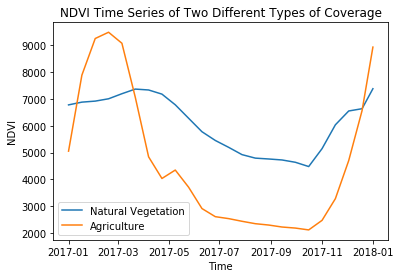

In [16]:
plt.plot(ts, ndvi[451,718], label="Natural Vegetation")
plt.plot(ts, ndvi[100,100], label="Agriculture")
plt.xlabel("Time")
plt.ylabel("NDVI")
plt.legend()
plt.title("NDVI Time Series of Two Different Types of Coverage")
plt.show()

### 4.1 Reference

Since different types of land cover/land use present variant spectral behavior along the time, a classification can be made using the DTW distance as a similarity factor. The method, as simple as this explanation goes, would be used to perform a pixel-based classification, ignoring the spatial relation between them, considering only the spectral response during the observation time for the pixel. To create the reference, samples should be acquired from the data to each class, and from them a reference time series can be fabricated.

To this project, the samples were acquired only for the "not deforested" area, and everything not classified as so, was classified as "deforested area". The following code gets the indexes of the reference series for the "not deforested areas", previously stored into a _.txt_ file.

In [17]:
arq_ref = open("./Data/Reference/reference_indices.txt", "r")
arq_ref.readline()

lines = arq_ref.readlines()
a = []

for line in lines:
    a += line.strip().split("\t")
    
reference = np.zeros([int(len(a)/2), 2], dtype=int)

b = 0
for i in range(0, int(len(a)), 2):
    reference[b,0] = int(a[i])
    reference[b,1] = int(a[i+1])
    b += 1
    
print(reference.shape)

(40, 2)


The samples were collected in groups of 4, located in spread locations in the study area, like the following plot shows.

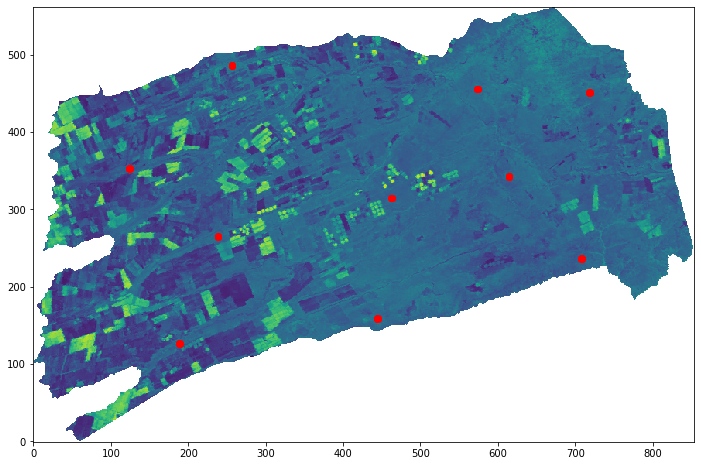

In [18]:
fig, ax = plt.subplots(figsize=(14, 8))
plt.imshow(evi[:,:,7], origin="lower")
for i in range(reference.shape[0]):
    plt.plot(reference[i,0], reference[i,1], "ro")

After retrieving the indexes of the reference for the classification, the series for each index is separated to be used later in the processes of reference series definition.

In [19]:
all_ref_blue = np.zeros([reference.shape[0], ts.shape[0]])
all_ref_red = np.zeros([reference.shape[0], ts.shape[0]])
all_ref_nir = np.zeros([reference.shape[0], ts.shape[0]])
all_ref_mir = np.zeros([reference.shape[0], ts.shape[0]])
all_ref_ndvi = np.zeros([reference.shape[0], ts.shape[0]])
all_ref_evi = np.zeros([reference.shape[0], ts.shape[0]])

for i in range(reference.shape[0]):
    all_ref_blue[i, :] = blue[reference[i,1], reference[i,0], :]
    all_ref_red[i, :] = red[reference[i,1], reference[i,0], :]
    all_ref_nir[i, :] = nir[reference[i,1], reference[i,0], :]
    all_ref_mir[i, :] = mir[reference[i,1], reference[i,0], :]
    all_ref_ndvi[i, :] = ndvi[reference[i,1], reference[i,0], :]
    all_ref_evi[i, :] = evi[reference[i,1], reference[i,0], :]

With all the reference series properly separated, a main series that represents the temporal spectral behavior for each one of the datasets could be built (blue, red, nir, mir, ndvi and evi). For example, to establish the reference series for the blue data, the median blue value of each timestamp group of values obtained from all input reference series was calculated, then this value was used as the final reference. By doing so, outliers that could not be purged by the previously methods did not greatly interfere during the building of the main reference.

In [20]:
ref_blue = np.zeros(ts.shape)
ref_red = np.zeros(ts.shape)
ref_nir = np.zeros(ts.shape)
ref_mir = np.zeros(ts.shape)
ref_ndvi = np.zeros(ts.shape)
ref_evi = np.zeros(ts.shape)

for i in range(0, ref_blue.shape[0], 1):
    ref_blue[i] = np.median(all_ref_blue[:,i])
    ref_red[i] = np.median(all_ref_red[:,i])
    ref_nir[i] = np.median(all_ref_nir[:,i])
    ref_mir[i] = np.median(all_ref_mir[:,i])
    ref_ndvi[i] = np.median(all_ref_ndvi[:,i])
    ref_evi[i] = np.median(all_ref_evi[:,i])

For a better visualization of the data, the following plot shows all the different references built (one for each dataset) and also each reference built in comparison to its origin data.

Text(0, 0.5, 'EVI')

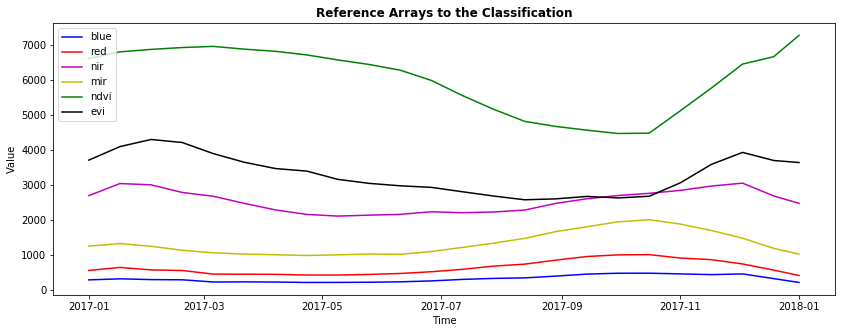

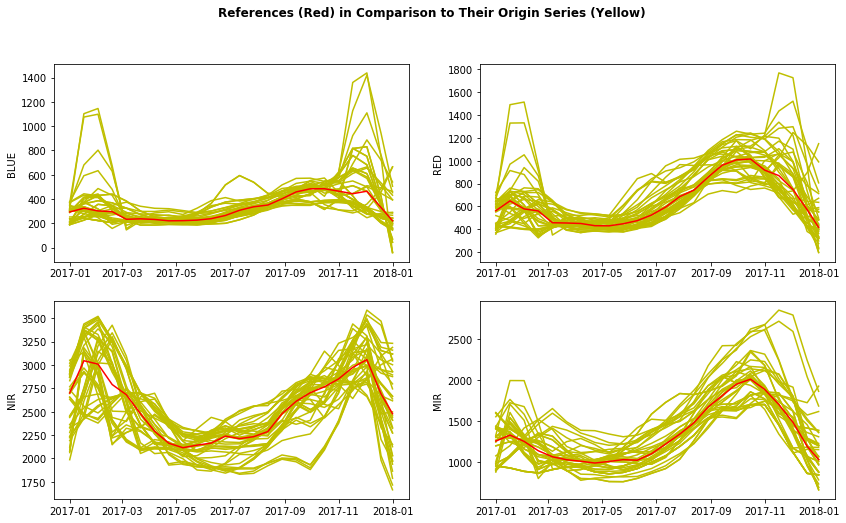

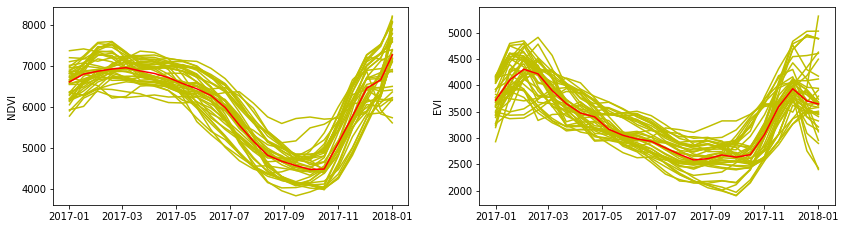

In [21]:
plt.figure(figsize=(14, 5))
plt.plot(ts, ref_blue, "b", label="blue")
plt.plot(ts, ref_red, "r", label="red")
plt.plot(ts, ref_nir, "m", label="nir")
plt.plot(ts, ref_mir, "y", label="mir")
plt.plot(ts, ref_ndvi, "g", label="ndvi")
plt.plot(ts, ref_evi, "k", label="evi")
plt.legend()
plt.ylabel("Value")
plt.xlabel("Time")
plt.title("Reference Arrays to the Classification", fontweight="bold")

plt.figure(figsize=(14, 8))
plt.suptitle("References (Red) in Comparison to Their Origin Series (Yellow)", fontweight="bold")
plt.subplot(221)
for i in range(all_ref_blue.shape[0]):
    plt.plot(ts, all_ref_blue[i, :], "y")
plt.plot(ts, ref_blue, "r")
plt.ylabel("BLUE")

plt.subplot(222)
for i in range(all_ref_red.shape[0]):
    plt.plot(ts, all_ref_red[i, :], "y")
plt.plot(ts, ref_red, "r")
plt.ylabel("RED")

plt.subplot(223)
for i in range(all_ref_nir.shape[0]):
    plt.plot(ts, all_ref_nir[i, :], "y")
plt.plot(ts, ref_nir, "r")
plt.ylabel("NIR")

plt.subplot(224)
for i in range(all_ref_mir.shape[0]):
    plt.plot(ts, all_ref_mir[i, :], "y")
plt.plot(ts, ref_mir, "r")
plt.ylabel("MIR")

plt.figure(figsize=(14, 8))

plt.subplot(221)
for i in range(all_ref_ndvi.shape[0]):
    plt.plot(ts, all_ref_ndvi[i, :], "y")
plt.plot(ts, ref_ndvi, "r")
plt.ylabel("NDVI")

plt.subplot(222)
for i in range(all_ref_evi.shape[0]):
    plt.plot(ts, all_ref_evi[i, :], "y")
plt.plot(ts, ref_evi, "r")
plt.ylabel("EVI")

### 4.2 Using the DTW Algorithm

The DTW algorithm can be easily used if the _fastdtw_ is imported, but this function has two different outputs: the distance between the series, and the match made among the nodes of the series. In order to use parallel processing tools, a function was created that returns only the needed information: the distance between the series, as can be seen below.

In [22]:
def dtw_fun(arr, ref):
    if not np.isnan(arr).any():
        return fastdtw(arr, ref, dist=euclidean)[0]
    else:
        return None

After the DTW function is defined, it could be used to calculate all the distances between each reference index and its respective final reference, as shown in the code below.

In [23]:
list_indices = []

for i in range(all_ref_blue.shape[0]):
    list_indices.append(i)

th_blue = None
th_red = None
th_nir = None
th_mir = None
th_ndvi = None
th_evi = None
        
with mp.Pool(processes=mp.cpu_count()) as pool:
    th_blue = pool.starmap(partial(dtw_fun), [(all_ref_blue[i,:], ref_blue) for i in list_indices])

with mp.Pool(processes=mp.cpu_count()) as pool:
    th_red = pool.starmap(partial(dtw_fun), [(all_ref_red[i,:], ref_red) for i in list_indices])
    
with mp.Pool(processes=mp.cpu_count()) as pool:
    th_nir = pool.starmap(partial(dtw_fun), [(all_ref_nir[i,:], ref_nir) for i in list_indices])
    
with mp.Pool(processes=mp.cpu_count()) as pool:
    th_mir = pool.starmap(partial(dtw_fun), [(all_ref_mir[i,:], ref_mir) for i in list_indices])
    
with mp.Pool(processes=mp.cpu_count()) as pool:
    th_ndvi = pool.starmap(partial(dtw_fun), [(all_ref_ndvi[i,:], ref_ndvi) for i in list_indices])
    
with mp.Pool(processes=mp.cpu_count()) as pool:
    th_evi = pool.starmap(partial(dtw_fun), [(all_ref_evi[i,:], ref_evi) for i in list_indices])

To have an idea of the data behavior, the DTW distances calculated in the previous cell could be shown in a group of boxplots below. Considering that all the reference points belong to the same class, it can be expected that other group of series that belong to the same class should present a similar behavior. The values for the DTW distance of deforested areas should be greater than the values presented here.

Text(0.5, 1.0, 'Reference Samples DTW Distances Calculated\nto the Final (Median) Reference')

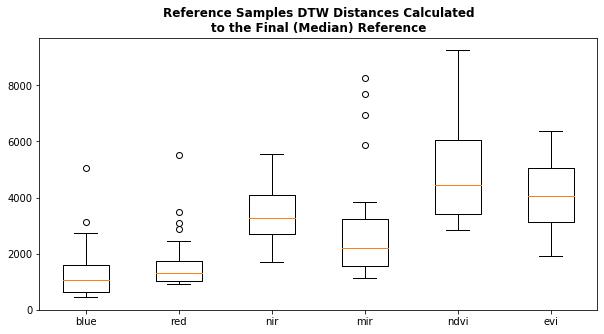

In [24]:
plt.figure(figsize=(10, 5))
plt.boxplot([th_blue, th_red, th_nir, th_mir, th_ndvi, th_evi])
plt.xticks([1, 2, 3, 4, 5, 6], ['blue', 'red', 'nir', 'mir', 'ndvi', 'evi'])
plt.title("Reference Samples DTW Distances Calculated\nto the Final (Median) Reference", fontweight="bold")

In [25]:
tt = time()

size = blue.shape

list_indices = []

for i in range(size[0]):
    for j in range(size[1]):
        list_indices.append([i,j])

result_blue = None
result_red = None
result_nir = None
result_mir = None
result_ndvi = None
result_evi = None

t = time()
print("Processing DTW BLUE...")
with mp.Pool(processes=mp.cpu_count()) as pool:
    result_blue = pool.starmap(partial(dtw_fun), [(blue[i,j,:], ref_blue) for (i,j) in list_indices])
print("Time: %.3f minutes" % ((time()-t)/60))

t = time()
print("Processing DTW RED...")
with mp.Pool(processes=mp.cpu_count()) as pool:
    result_red = pool.starmap(partial(dtw_fun), [(red[i,j,:], ref_red) for (i,j) in list_indices])
print("Time: %.3f minutes" % ((time()-t)/60))

t = time()
print("Processing DTW NIR...")
with mp.Pool(processes=mp.cpu_count()) as pool:
    result_nir = pool.starmap(partial(dtw_fun), [(nir[i,j,:], ref_nir) for (i,j) in list_indices])
print("Time: %.3f minutes" % ((time()-t)/60))

t = time()
print("Processing DTW MIR...")
with mp.Pool(processes=mp.cpu_count()) as pool:
    result_mir = pool.starmap(partial(dtw_fun), [(mir[i,j,:], ref_mir) for (i,j) in list_indices])
print("Time: %.3f minutes" % ((time()-t)/60))

t = time()
print("Processing DTW NDVI...")
with mp.Pool(processes=mp.cpu_count()) as pool:
    result_ndvi = pool.starmap(partial(dtw_fun), [(ndvi[i,j,:], ref_ndvi) for (i,j) in list_indices])
print("Time: %.3f minutes" % ((time()-t)/60))

t = time()
print("Processing DTW EVI...")
with mp.Pool(processes=mp.cpu_count()) as pool:
    result_evi = pool.starmap(partial(dtw_fun), [(evi[i,j,:], ref_evi) for (i,j) in list_indices])
print("Time: %.3f minutes" % ((time()-t)/60))

dist_blue = np.zeros((size[0], size[1]), dtype=float)
dist_red  = np.zeros((size[0], size[1]), dtype=float)
dist_nir  = np.zeros((size[0], size[1]), dtype=float)
dist_mir  = np.zeros((size[0], size[1]), dtype=float)
dist_ndvi = np.zeros((size[0], size[1]), dtype=float)
dist_evi  = np.zeros((size[0], size[1]), dtype=float)

for i in range(0, size[0]):
    dist_blue[i,:] = result_blue[i*size[1]:i*size[1]+size[1]]
    dist_red[i,:] = result_red[i*size[1]:i*size[1]+size[1]]
    dist_nir[i,:] = result_nir[i*size[1]:i*size[1]+size[1]]
    dist_mir[i,:] = result_mir[i*size[1]:i*size[1]+size[1]]
    dist_ndvi[i,:] = result_ndvi[i*size[1]:i*size[1]+size[1]]
    dist_evi[i,:] = result_evi[i*size[1]:i*size[1]+size[1]]

print("Total Time: %.3f minutes" % ((time()-tt)/60))

Processing DTW BLUE...
Time: 12.496 minutes
Processing DTW RED...
Time: 12.641 minutes
Processing DTW NIR...
Time: 12.716 minutes
Processing DTW MIR...
Time: 12.594 minutes
Processing DTW NDVI...
Time: 12.582 minutes
Processing DTW EVI...
Time: 12.526 minutes
Total Time: 75.564 minutes


Text(0, 0.5, '')

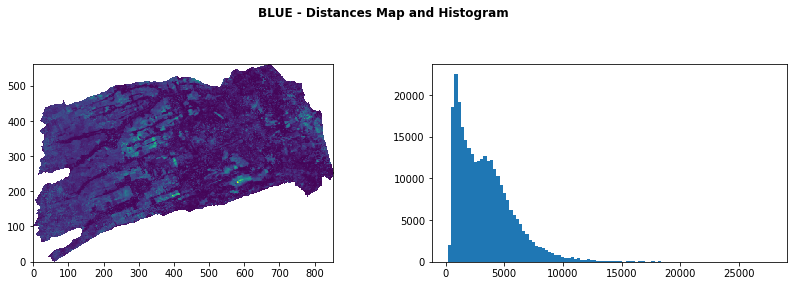

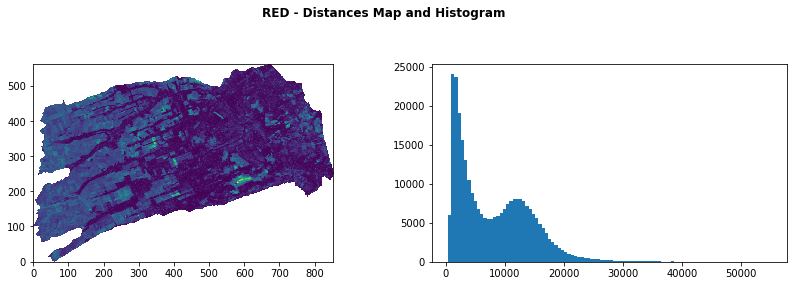

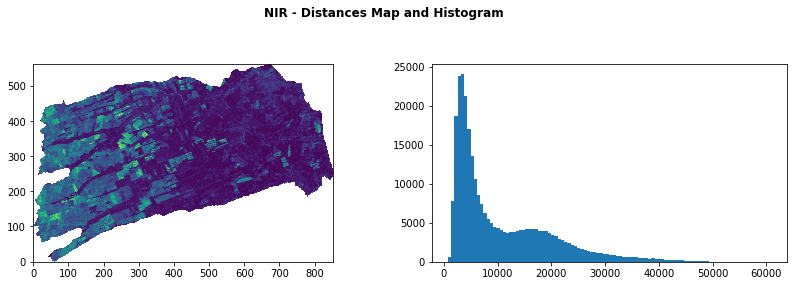

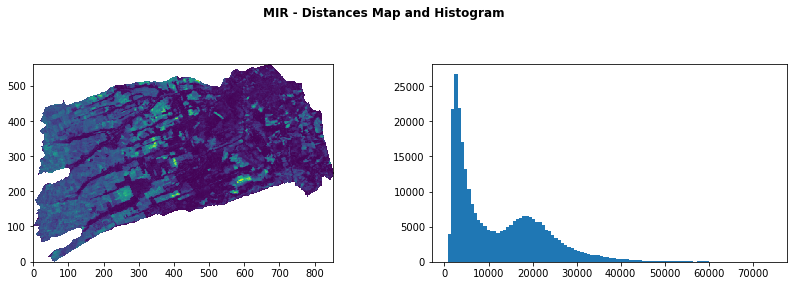

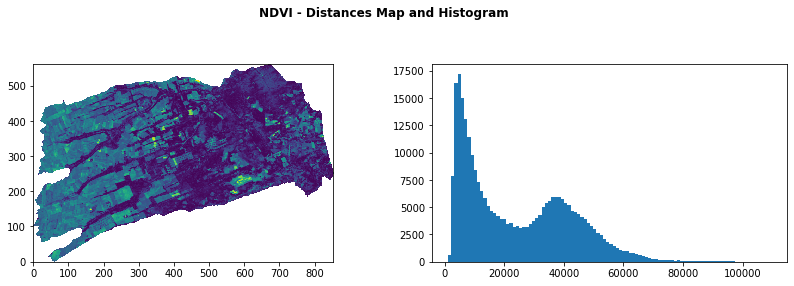

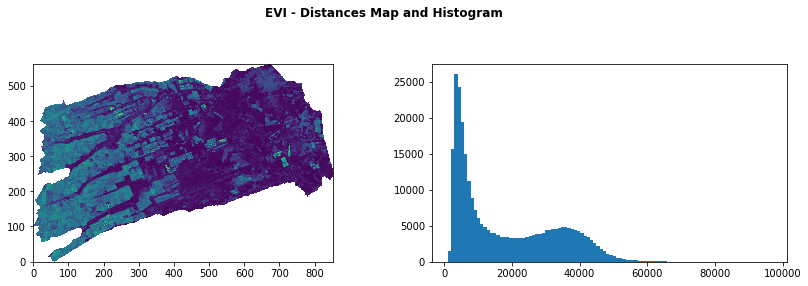

In [40]:
np.warnings.filterwarnings('ignore')

#
plt.figure(figsize=(14, 8))
plt.suptitle("BLUE - Distances Map and Histogram", fontweight="bold")

plt.subplot(221)
plt.imshow(dist_blue, origin="lower")

plt.subplot(222)
plt.hist(dist_blue.ravel(), bins=100)
plt.ylabel("")

#
plt.figure(figsize=(14, 8))
plt.suptitle("RED - Distances Map and Histogram", fontweight="bold")

plt.subplot(221)
plt.imshow(dist_red, origin="lower")

plt.subplot(222)
plt.hist(dist_red.ravel(), bins=100)
plt.ylabel("")

#
plt.figure(figsize=(14, 8))
plt.suptitle("NIR - Distances Map and Histogram", fontweight="bold")

plt.subplot(221)
plt.imshow(dist_nir, origin="lower")

plt.subplot(222)
plt.hist(dist_nir.ravel(), bins=100)
plt.ylabel("")

#
plt.figure(figsize=(14, 8))
plt.suptitle("MIR - Distances Map and Histogram", fontweight="bold")

plt.subplot(221)
plt.imshow(dist_mir, origin="lower")

plt.subplot(222)
plt.hist(dist_mir.ravel(), bins=100)
plt.ylabel("")

#
plt.figure(figsize=(14, 8))
plt.suptitle("NDVI - Distances Map and Histogram", fontweight="bold")

plt.subplot(221)
plt.imshow(dist_ndvi, origin="lower")

plt.subplot(222)
plt.hist(dist_ndvi.ravel(), bins=100)
plt.ylabel("")

#
plt.figure(figsize=(14, 8))
plt.suptitle("EVI - Distances Map and Histogram", fontweight="bold")

plt.subplot(221)
plt.imshow(dist_evi, origin="lower")

plt.subplot(222)
plt.hist(dist_evi.ravel(), bins=100)
plt.ylabel("")

## 4. Classification

In this part, a DTW algorithm is used.

In [27]:
d_blue = np.zeros([all_ref_blue.shape[0]])
d_red  = np.zeros([all_ref_blue.shape[0]])
d_nir  = np.zeros([all_ref_blue.shape[0]])
d_mir  = np.zeros([all_ref_blue.shape[0]])
d_ndvi = np.zeros([all_ref_blue.shape[0]])
d_evi  = np.zeros([all_ref_blue.shape[0]])


for i in range(all_ref_blue.shape[0]):
    d_blue[i] = fastdtw(all_ref_blue[i,:], ref_blue, dist=euclidean)[0]
    d_red[i]  = fastdtw(all_ref_red[i,:], ref_red, dist=euclidean)[0]
    d_nir[i]  = fastdtw(all_ref_nir[i,:], ref_nir, dist=euclidean)[0]
    d_mir[i]  = fastdtw(all_ref_mir[i,:], ref_mir, dist=euclidean)[0]
    d_ndvi[i] = fastdtw(all_ref_ndvi[i,:], ref_ndvi, dist=euclidean)[0]
    d_evi[i]  = fastdtw(all_ref_evi[i,:], ref_evi, dist=euclidean)[0]

In [28]:
th_blue = np.percentile(d_blue, 100)*2.5
th_red  = np.percentile(d_red , 100)*2.5
th_nir  = np.percentile(d_nir , 100)*2.5
th_mir  = np.percentile(d_mir , 100)*2.5
th_ndvi = np.percentile(d_ndvi, 100)*2.5
th_evi  = np.percentile(d_evi , 100)*2.5

In [39]:
map_blue = np.zeros(dist_blue.shape)
map_red  = np.zeros(dist_red.shape)
map_nir  = np.zeros(dist_nir.shape)
map_mir  = np.zeros(dist_mir.shape)
map_ndvi = np.zeros(dist_ndvi.shape)
map_evi  = np.zeros(dist_evi.shape)

np.warnings.filterwarnings('ignore')

map_blue[dist_blue>th_blue] = 0
map_blue[dist_blue<=th_blue] = 1

map_red[dist_red> th_red] = 0
map_red[dist_red<=th_red] = 1

map_nir[dist_nir> th_nir] = 0
map_nir[dist_nir<=th_nir] = 1

map_mir[dist_mir> th_mir] = 0
map_mir[dist_mir<=th_mir] = 1

map_ndvi[dist_ndvi> th_ndvi] = 0
map_ndvi[dist_ndvi<=th_ndvi] = 1

map_evi[dist_evi> th_evi] = 0
map_evi[dist_evi<=th_evi] = 1

for i in range(dist_blue.shape[0]):
    for j in range(dist_blue.shape[1]):
        if np.isnan(dist_blue[i,j]):
            map_blue[i,j] = None
            map_red[i,j] = None
            map_nir[i,j] = None
            map_mir[i,j] = None
            map_ndvi[i,j] = None
            map_evi[i,j] = None

1.0 0.0


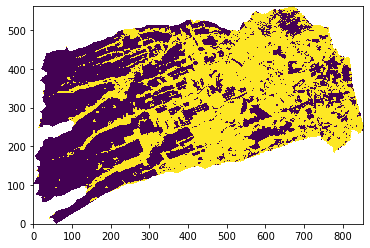

In [30]:
map_final = np.zeros(dist_evi.shape)

for i in range(dist_blue.shape[0]):
    for j in range(dist_blue.shape[1]):
        if np.isnan(map_blue[i,j]):
            map_final[i,j] = None
        elif map_blue[i,j]==1 and map_red[i,j]==1 and map_nir[i,j]==1 and map_ndvi[i,j]==1 and map_evi[i,j]==1:
            map_final[i,j] = 1
            
plt.imshow(map_final, origin="lower")
print(np.nanmax(map_final), np.nanmin(map_final))

## 5. PRODES Data

PRODES provides the deforestation areas for the entire Cerrado biome, in the _shapefile_ format. In this case, the areas are acquired by visual interpretation, done by trained analysts, what guarantee a high level of accuracy. The idea is to use PRODES data to identify training areas, and then apply the algorithms to the savannas identification.

A simple visualization of the PRODES data can be seen below, as well as an approximation to the study area.

<img src="./Images/prodes.png" width="700">

The data is composed of a series of polygons, which represent the deforestation of the Cerrado until the end of 2018. This data is then cropped to the study area, like in the code below.

Text(0.5, 1, 'epsg:4674')

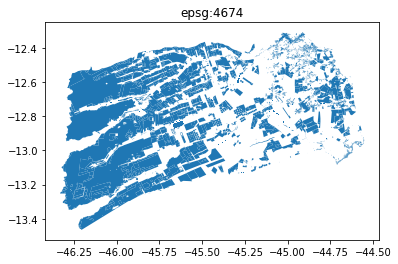

In [31]:
prodes = gp.read_file("./Data/Shape/prodes.shp", encoding="utf-8")

prodes.plot()
plt.title(str(prodes.crs['init']))

Text(0.5, 1, 'epsg:4326')

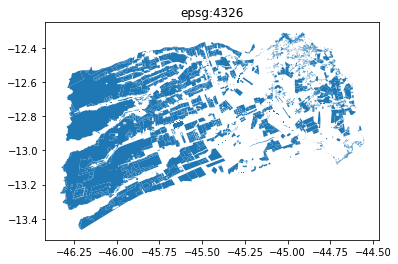

In [32]:
prodes = prodes.to_crs({'init': 'epsg:4326'})

prodes.plot()
plt.title(str(prodes.crs['init']))

In [33]:
prodes.head()

UID ORIGIN_GID PATHROW   VIEW_DATE        SOURCE CLASSNAME  AREAMUNKM  \
0  305721.0    1393597  220/69  2006-08-04  inpe cerrado    D_2006   0.039290   
1  306022.0    1393977  220/69  2006-08-04  inpe cerrado    D_2006   0.021477   
2  690466.0    1985583  220/69  2004-10-01  inpe cerrado    D_2004   1.698738   
3  853226.0    2241870  220/69  2002-09-02  inpe cerrado    D_2002   0.014715   
4  853272.0    2241927  220/69  2002-09-02  inpe cerrado    D_2002   4.004511   

                COUNTY  UF                                           geometry  
0        SÃO DESIDÉRIO  BA  POLYGON ((-45.85059122240693 -12.6904455168470...  
1        SÃO DESIDÉRIO  BA  POLYGON ((-45.46654814158342 -12.4179271651065...  
2        SÃO DESIDÉRIO  BA  POLYGON ((-45.7633578571793 -13.12846016830207...  
3        SÃO DESIDÉRIO  BA  POLYGON ((-45.2511093967812 -12.5249730392743,...  
4  AURORA DO TOCANTINS  TO  POLYGON ((-46.15229088629243 -12.5112800268714...

In [34]:
prodes.sort_values("VIEW_DATE", ascending=False).head()

UID ORIGIN_GID PATHROW   VIEW_DATE        SOURCE CLASSNAME  \
4050  1375518.0      43094  220/69  2018-08-21  inpe cerrado    D_2018   
4020  1374551.0      43004  220/69  2018-08-21  inpe cerrado    D_2018   
4018  1374386.0      42989  220/69  2018-08-21  inpe cerrado    D_2018   
4017  1374375.0      42988  220/69  2018-08-21  inpe cerrado    D_2018   
4016  1374487.0      42999  220/69  2018-08-21  inpe cerrado    D_2018   

      AREAMUNKM         COUNTY  UF  \
4050   0.021645  SÃO DESIDÉRIO  BA   
4020   0.017842  SÃO DESIDÉRIO  BA   
4018   0.015076  SÃO DESIDÉRIO  BA   
4017   0.062733  SÃO DESIDÉRIO  BA   
4016   0.035330  SÃO DESIDÉRIO  BA   

                                               geometry  
4050  POLYGON ((-45.49016695643985 -12.4739742918800...  
4020  POLYGON ((-45.11121715544732 -12.6783488043537...  
4018  POLYGON ((-45.860313239964 -12.68626779901967,...  
4017  POLYGON ((-45.06677652341779 -12.6869763119072...  
4016  POLYGON ((-45.84069018670272 -12.6704570879242...

In [35]:
prodes.to_file("./Data/Shape/prodes_epsg4326.shp")

In [36]:
i, j = map_final.shape

warpCmd = 'gdal_rasterize -l prodes_epsg4326 -burn 1.0 -ts {0} {1} -a_nodata 0.0 -te {2} {3} {4} {5} -ot Float32 -of GTiff {6} {7}'.format(
                    j, i, long1, lat1, long2, lat2, './Data/Shape/prodes_epsg4326.shp', './Data/Reference/ref_prodes.tif')
subprocess.call(warpCmd, shell=True)

0

1.0 0.0


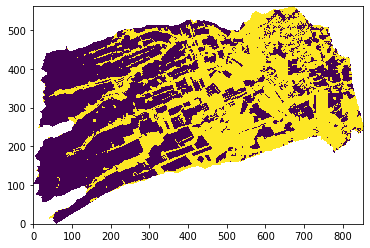

In [37]:
ref = np.flip(gdal.Open('./Data/Reference/ref_prodes.tif').ReadAsArray(), 0)*-1+1

for i in range(dist_blue.shape[0]):
    for j in range(dist_blue.shape[1]):
        if np.isnan(dist_blue[i,j]):
            ref[i,j] = None

plt.imshow(ref, origin="lower")
print(np.nanmax(ref), np.nanmin(ref))

## 6. Comparison

[[129580  24513]
 [ 15477 119387]]
Global Accuracy: 0.8616
Kappa: 0.7231


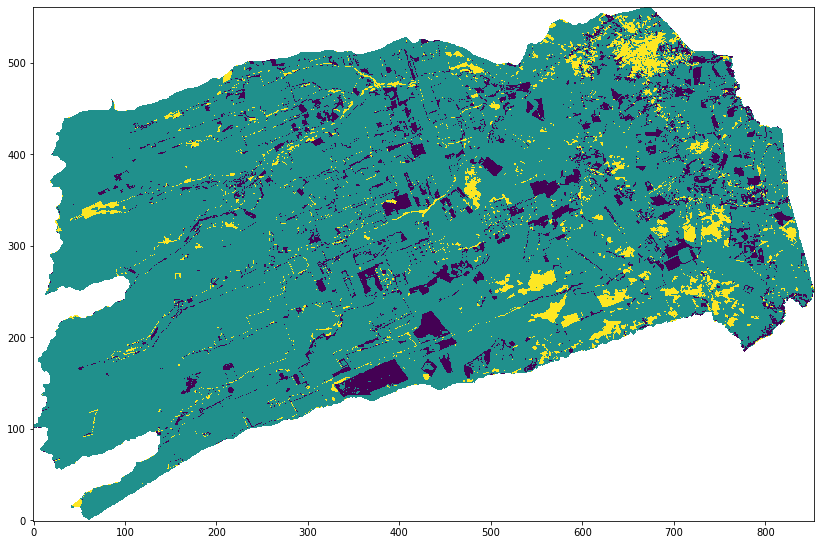

In [38]:
fig = plt.figure(figsize=(14,14))
map_diff = ref-map_final
plt.imshow(map_diff, origin="lower")

list_ref = []
list_map = []

for i in range(map_diff.shape[0]):
    for j in range(map_diff.shape[1]):
        if not np.isnan(map_diff[i,j]):
            list_ref.append(ref[i,j])
            list_map.append(map_final[i,j])

conf_matr = cm(list_ref, list_map)

print(conf_matr)
print("Global Accuracy: %.4f" % ((conf_matr[0,0]+conf_matr[1,1])/np.sum(conf_matr.ravel())))

k = kappa(list_ref, list_map)
print("Kappa: %.4f" % (k))

## 7. Conclusion

With this methodology is expected to achieve a classification of the land cover/land use of the study area, regarding two classes: deforested area and not-deforested area. The accuracy expected is not high, in comparison with the product of PRODES.

Behind all the methods here described is the intention to automatize the PRODES process. High quality results, comparable with the PRODES product are not possible to achieve with such a simple work flow, but it can be the right step in the direction of the algorithms to be used in the creation of the PRODES product in the future.